In [321]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from math import floor
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
from os.path import exists as DoesPathExist
train_logs_path = "/kaggle/input/linking-writing-processes-to-writing-quality/train_logs.csv"
train_scores_path = "/kaggle/input/linking-writing-processes-to-writing-quality/train_scores.csv"
test_logs_path = "/kaggle/input/linking-writing-processes-to-writing-quality/test_logs.csv"
sample_submission_path = "/kaggle/input/linking-writing-processes-to-writing-quality/sample_submission.csv"

if DoesPathExist(train_logs_path):
    train_logs: pd.DataFrame = pd.read_csv(train_logs_path)
else:
    train_logs: pd.DataFrame = pd.read_csv("./data/train_logs.csv")

if DoesPathExist(train_scores_path):
    train_scores = pd.read_csv(train_scores_path)
else:
    train_scores = pd.read_csv("./data/train_scores.csv")

if DoesPathExist(test_logs_path):
    test_logs = pd.read_csv(test_logs_path)
else:
    test_logs = pd.read_csv("./data/test_logs.csv")
    
if DoesPathExist(sample_submission_path):
    sample_submission = pd.read_csv(sample_submission_path)
else:
    sample_submission = pd.read_csv("./data/sample_submission.csv")
    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('expand_frame_repr', False)

In [322]:
train_logs.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


In [323]:
train_scores.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


In [324]:
train_logs.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.999]).round(0)

,event_id,down_time,up_time,action_time,cursor_position,word_count
count,8405898.0,8405898.0,8405898.0,8405898.0,8405898.0,8405898.0
mean,2068.0,793560.0,793658.0,98.0,1223.0,231.0
std,1588.0,514945.0,514943.0,253.0,949.0,176.0
min,1.0,106.0,252.0,0.0,0.0,0.0
1%,35.0,47863.0,47964.0,0.0,9.0,2.0
5%,171.0,109978.0,110076.0,12.0,87.0,18.0
25%,852.0,373184.0,373282.0,66.0,499.0,96.0
50%,1726.0,720886.0,720980.0,93.0,1043.0,200.0
75%,2926.0,1163042.0,1163141.0,122.0,1706.0,327.0
95%,5121.0,1664020.0,1664111.0,176.0,3037.0,565.0


## Data Analysis

#### Word Count Analysis
Here we will be looking at the effect of the word count on the outcome.

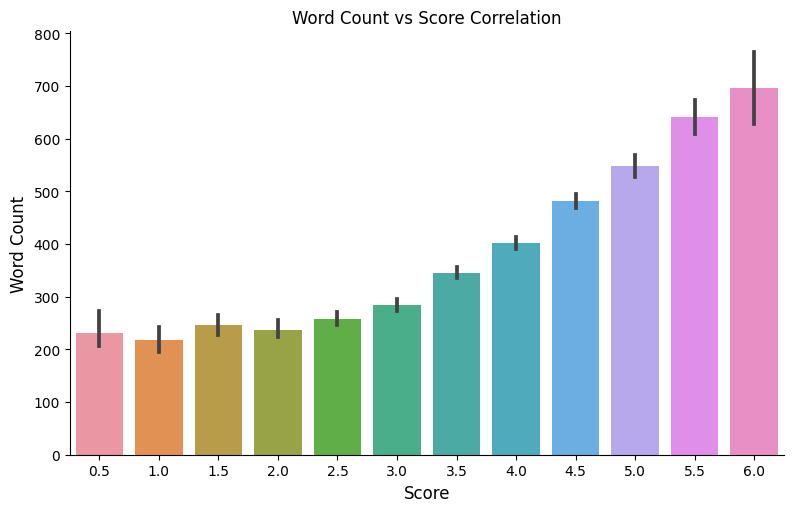

In [325]:
stats = train_logs.groupby("id")["word_count"].max().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="word_count", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Word Count', fontsize=12)
plt.title("Word Count vs Score Correlation")
plt.show()

In [326]:
stats.describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).round(1)

,word_count
count,2471.0
mean,390.0
std,172.5
min,35.0
1%,199.7
5%,204.0
25%,255.0
50%,351.0
75%,480.0
95%,724.0


#### Event Analysis

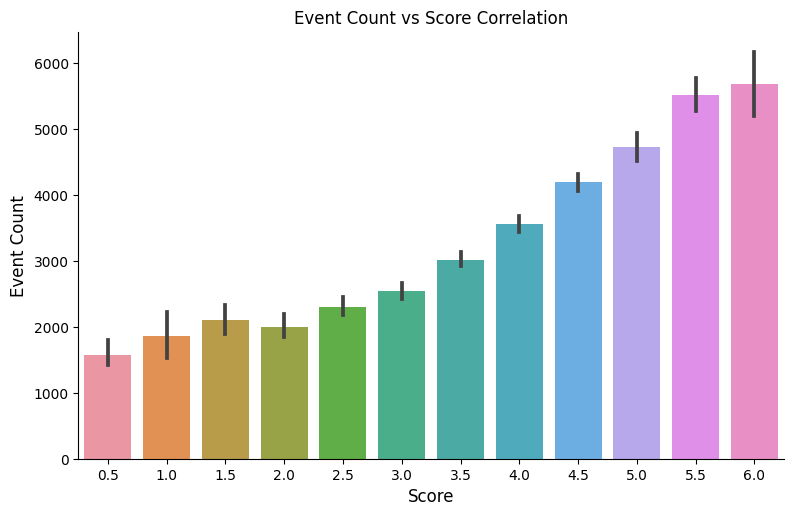

In [327]:
stats = train_logs.groupby("id")["event_id"].max().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="event_id", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('Event Count', fontsize=12)
plt.title("Event Count vs Score Correlation")
plt.show()

In [328]:
stats.describe(percentiles=[0.02, 0.05, 0.25, 0.5, 0.75, 0.95, 0.98]).round(1)

,event_id
count,2471.0
mean,3401.8
std,1578.9
min,262.0
2%,1377.8
5%,1524.5
25%,2193.5
50%,3082.0
75%,4301.0
95%,6387.5


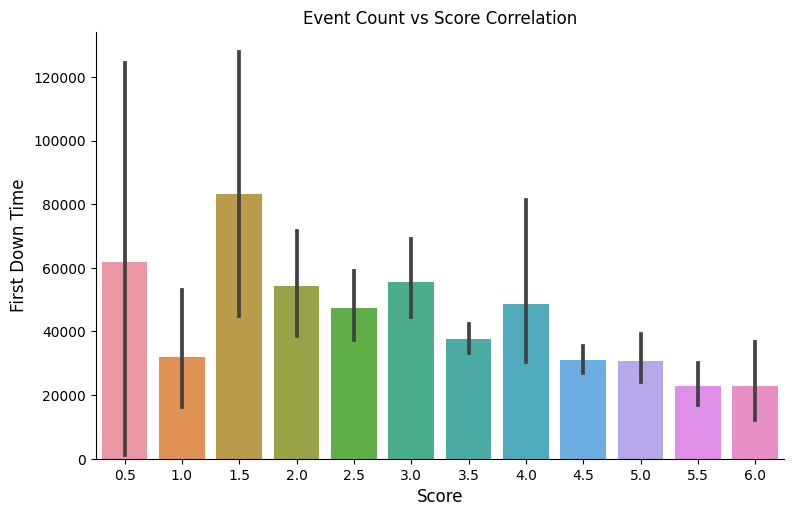

In [329]:
stats = train_logs.groupby("id")["down_time"].min().reset_index()
stats_score = stats.merge(train_scores, on='id')

catplot = sns.catplot(data=stats_score, x="score", y="down_time", kind="bar", height=5, aspect=8/5)
plt.xlabel('Score', fontsize=12)
plt.ylabel('First Down Time', fontsize=12)
plt.title("Event Count vs Score Correlation")
plt.show()

## Data preprocessing

##### Removing Outliers

In [330]:
MAX_EVENT_START_TIME = 1_800_000 # miliseconds in 30 minutes.
NUMBER_OF_INTERVALS = 1_800 # = 1_800_000 msec / 250 milisecond intervals
MAX_ACTION_TIME = 250
NUM_FEATURES = 9
PUNCUATION = ['!', '"', "'", '(', ')', ',', '.', ':', ';','?', '¡', '¿', '\\']
def ScoreOneHot(score: float) -> np.array:
    result = np.zeros(12)
    result[int(score / 0.5) - 1] = 1
    return result
    

def TrainingPrep(df: pd.DataFrame):

    indexs_to_drop = df[df["down_time"] > df.down_time.quantile(0.999)].index
    df.drop(indexs_to_drop, inplace=True)
    indexs_to_drop = df[df["up_time"] > df.down_time.quantile(0.999)].index
    df.drop(indexs_to_drop, inplace=True)

    return df

def DfToX(df: pd.DataFrame, scores: pd.DataFrame = None) -> np.array:
    indexs_to_drop = df[df["action_time"] > MAX_ACTION_TIME].index
    df.drop(indexs_to_drop, inplace=True)

    x_train = np.zeros((len(np.unique(df["id"])), NUM_FEATURES, int(NUMBER_OF_INTERVALS)))
    y_train = np.zeros((len(np.unique(df["id"])), 12))
    groups = df.groupby("id")

    for index, id in enumerate(df["id"].unique()):
        if scores is not None:
            y_train[index] = ScoreOneHot(scores[scores["id"] == id].iloc[0]["score"])

        essayGroup = groups.get_group(id)
        max = essayGroup["down_time"].quantile(0.99)
        min = essayGroup["down_time"].quantile(0.01)
        range = max - min
        if range == 0:
            range = 1

        MAX_WORD_COUNT = essayGroup["word_count"].max()
        MAX_CURSOR_POSITION = essayGroup["cursor_position"].max()

        for row in essayGroup.itertuples():
            
            if (row.down_time < min*0.9) or (row.down_time > max*1.1):
                continue

            start_index = floor(((row.down_time - min) / range) * NUMBER_OF_INTERVALS)

            if start_index >= NUMBER_OF_INTERVALS:
                start_index = NUMBER_OF_INTERVALS - 1

            if start_index < 0:
                start_index = 0
            
            match row.activity:
                case "Nonproduction":
                    x_train[index][2][start_index] += 1.0
                case "Input" | "Replace":
                    # Puncuation
                    if row.down_event in PUNCUATION:
                        x_train[index][6][start_index] += 1.0
                    elif row.down_event == "q":
                        x_train[index][7][start_index] += 1.0
                    else:
                        x_train[index][8][start_index] += 1.0

                case "Remove/Cut":
                    x_train[index][4][start_index] += 1.0
                case "Paste":
                    x_train[index][5][start_index] += 1.0
                case _:
                    if "Move From" in row.activity:
                        x_train[index][3][start_index] += 1.0
            
            if x_train[index][0][start_index] < row.word_count / MAX_WORD_COUNT:
                x_train[index][0][start_index] = row.word_count / MAX_WORD_COUNT
            
            if x_train[index][1][start_index] < row.cursor_position / MAX_WORD_COUNT:
                x_train[index][1][start_index] = row.cursor_position / MAX_CURSOR_POSITION
        
        currentWordCount = 0
        for i, wordCount in enumerate(np.nditer(x_train[index][0])):
            if wordCount == 0:
                x_train[index][0] = currentWordCount
            elif currentWordCount != wordCount:
                currentWordCount = wordCount

        currentCursorPosition = 0
        for i, cursor in enumerate(np.nditer(x_train[index][1])):
            if cursor == 0:
                x_train[index][1] = currentCursorPosition
            elif cursor != currentCursorPosition:
                currentCursorPosition = cursor
        
    x_train = np.transpose(x_train, axes=(0, 2, 1))
    return x_train, y_train

TrainingPrep(train_logs)
x_all_train, y_all_train = DfToX(train_logs, train_scores)

In [331]:
x_train, x_test, y_train, y_test = train_test_split(x_all_train, y_all_train, train_size=0.8, test_size=0.2)
print(y_train)
print(f"Train: {len(x_train)}")
print(f"Test: {len(x_test)}")

del x_all_train
del y_all_train

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Train: 1976
Test: 494


In [332]:
print(x_train.shape)
print(type(x_train[0][0][0]))
# for row in x_train[0]:
#     print(row)

(1976, 1800, 9)
<class 'numpy.float64'>


In [333]:
input_shape = (len(x_train), len(x_train[0]), len(x_train[0][0]))
print(input_shape)

model = models.Sequential()
model.add(layers.InputLayer(input_shape=input_shape[1:], dtype=np.float64))
model.add(layers.Normalization())

model.add(layers.Conv1D(filters=64, kernel_size = (4,), strides=1, padding="SAME", activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.AveragePooling1D())

model.add(layers.Conv1D(filters=16, kernel_size = (4,), strides=1, padding="SAME", activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling1D())

model.add(layers.Conv1D(filters=16, kernel_size = (2,), strides=1, padding="SAME", activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l=0.01)))
model.add(layers.MaxPooling1D())

model.add(layers.Flatten())

model.add(layers.Dense(units=3600,activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(units=4096,activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(units=4096,activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(units=512,activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(units=16,activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=12,activation=tf.keras.activations.softmax))
model.summary()

(1976, 1800, 9)
Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_23 (Normaliz  (None, 1800, 9)           19        
 ation)                                                          
                                                                 
 conv1d_69 (Conv1D)          (None, 1800, 64)          2368      
                                                                 
 average_pooling1d_23 (Aver  (None, 900, 64)           0         
 agePooling1D)                                                   
                                                                 
 conv1d_70 (Conv1D)          (None, 900, 16)           4112      
                                                                 
 max_pooling1d_46 (MaxPooli  (None, 450, 16)           0         
 ng1D)                                                           
                                     

In [334]:
metrics = [tf.keras.metrics.RootMeanSquaredError()]
model.compile(optimizer='adam', 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=metrics)

In [335]:
epochs = 10
history = model.fit(x_train, y_train, epochs=epochs, validation_split=0.14)

Epoch 1/10
54/54 [==============================] - 7s 113ms/step - loss: 2.9048 - root_mean_squared_error: 0.2744 - val_loss: 2.6820 - val_root_mean_squared_error: 0.2705
Epoch 2/10
54/54 [==============================] - 6s 111ms/step - loss: 2.6361 - root_mean_squared_error: 0.2714 - val_loss: 2.6427 - val_root_mean_squared_error: 0.2725
Epoch 3/10
54/54 [==============================] - 6s 113ms/step - loss: 2.4891 - root_mean_squared_error: 0.2690 - val_loss: 2.5938 - val_root_mean_squared_error: 0.2704
Epoch 4/10
54/54 [==============================] - 6s 112ms/step - loss: 2.3519 - root_mean_squared_error: 0.2664 - val_loss: 2.4415 - val_root_mean_squared_error: 0.2689
Epoch 5/10
54/54 [==============================] - 6s 112ms/step - loss: 2.2196 - root_mean_squared_error: 0.2634 - val_loss: 2.4829 - val_root_mean_squared_error: 0.2680
Epoch 6/10
54/54 [==============================] - 8s 146ms/step - loss: 2.1216 - root_mean_squared_error: 0.2600 - val_loss: 2.6737 - val_

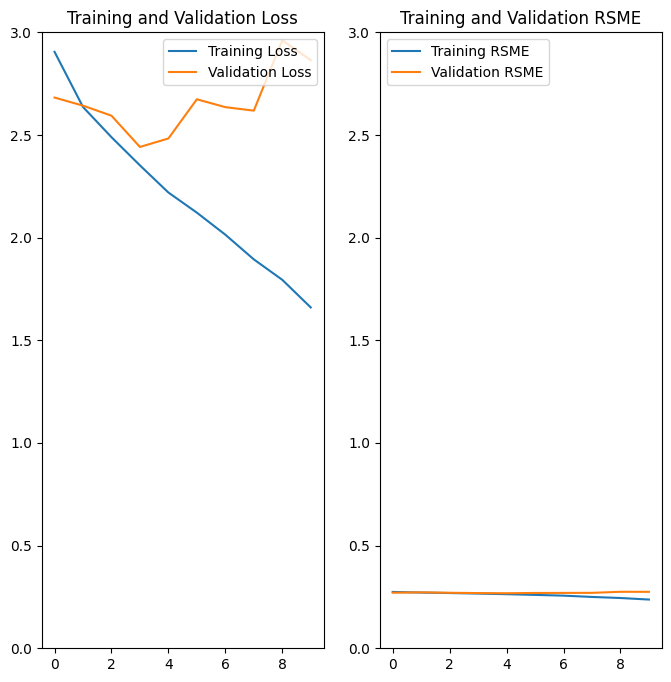

In [336]:
loss = history.history['loss']
val_loss = history.history['val_loss']

RMSE = history.history['root_mean_squared_error']
val_RMSE = history.history['val_root_mean_squared_error']
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
ax = plt.subplot(1, 2, 1)
ax.set_ylim(0, 3)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

ax = plt.subplot(1, 2, 2)
ax.set_ylim(0, 3)
plt.plot(epochs_range, RMSE, label='Training RSME')
plt.plot(epochs_range, val_RMSE, label='Validation RSME')
plt.legend(loc='upper left')
plt.title('Training and Validation RSME')
plt.show()

In [337]:
model.evaluate(x_test, y_test)

16/16 [==============================] - 0s 23ms/step - loss: 2.8825 - root_mean_squared_error: 0.2743


[2.8824870586395264, 0.2743171453475952]

In [338]:
def OneColdCode(arr: list) -> float:
    print(arr)
    score = 0.5
    max_score = 0.5
    highests = 0
    for i in arr:
        if i >= highests:
            highests = i
            max_score = score
        score += 0.5
    return max_score

def HalfRound(a: float) -> float:
    return round(a * 2) / 2.0

#test_logs = pd.read_csv("./data/personaltest.csv")

predictions = []
for id in test_logs["id"].unique():
    pred_score = 3.5
    try:
        x_test, y_test = DfToX(test_logs[test_logs["id"] == id])
        pred = model.predict(x_test)
        pred_score = OneColdCode(pred[0])
        #pred_score = HalfRound(pred[0][0])
        #pred_score = pred[0][0]
    except ValueError as ex:
        pred_score = 3.5
        print(f"VALUE ERROR OCCURED. ERROR: {ex}")
    except Exception as ex:
        print(f"ERROR: {ex}")
        pred_score = 3.5
    finally:
        predictions.append((id, pred_score))
    print((id, pred_score))

ids = [p[0] for p in predictions]
scores = [p[1] for p in predictions]

sample_submission["id"] = ids
sample_submission["score"] = scores
sample_submission[["id", "score"]].to_csv("submission.csv", index=False)

1/1 [==============================] - 0s 71ms/step
[0.01199894 0.05159892 0.08876839 0.06888729 0.19514008 0.22705668
 0.07050235 0.01976795 0.08097263 0.03606906 0.08321606 0.06602169]
('0000aaaa', 3.0)
1/1 [==============================] - 0s 18ms/step
[0.0120969  0.05170705 0.08872911 0.06899689 0.19470486 0.22655404
 0.07068937 0.01991243 0.08108018 0.03620282 0.08326814 0.06605833]
('2222bbbb', 3.0)
1/1 [==============================] - 0s 16ms/step
[0.01193495 0.05152782 0.08879396 0.06881513 0.19542609 0.227387
 0.07037947 0.0196735  0.08090177 0.0359813  0.08318158 0.06599741]
('4444cccc', 3.0)


/var/folders/tc/wt4t3d6s7cj2_wczz6yqs0zm0000gn/T/ipykernel_61159/970481107.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(indexs_to_drop, inplace=True)
/var/folders/tc/wt4t3d6s7cj2_wczz6yqs0zm0000gn/T/ipykernel_61159/970481107.py:76: RuntimeWarning: invalid value encountered in scalar divide
  if x_train[index][0][start_index] < row.word_count / MAX_WORD_COUNT:
/var/folders/tc/wt4t3d6s7cj2_wczz6yqs0zm0000gn/T/ipykernel_61159/970481107.py:79: RuntimeWarning: invalid value encountered in scalar divide
  if x_train[index][1][start_index] < row.cursor_position / MAX_WORD_COUNT:
/var/folders/tc/wt4t3d6s7cj2_wczz6yqs0zm0000gn/T/ipykernel_61159/970481107.py:79: RuntimeWarning: divide by zero encountered in scalar divide
  if x_train[index][1][start_index] < row.cursor_position / MAX_WORD_COUNT:
